# 1 - Perkenalan

Megatheo J Rumahorbo FTDS Batch 11 Phase 2

Dataset : Google Play Store Reviews

Data berisikan reviews dari aplikasi yang ada di Googgle Play Store. Informasi yang disediakan mulai dari nama aplikasi, reviews, dan sentimen.

Objective:
- Membuat Neural Network Model untuk Kasus Sentimen Analysis 

# 2 - Import Library

In [1]:
# Import Libarys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from keras.models import load_model
tf.random.set_seed(42)
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import classification_report
import string
import functools

In [2]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# 3 - Data Loading

In [3]:
# Load Data
df = pd.read_csv('googleplaystore_user_reviews.csv')
df.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


In [4]:
# Check Shape
df.shape

(64295, 5)

In [5]:
# Check Missing Values
df.isnull().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

Terlihat Terdapat 26868 baris yang missing values, kita akan mendrop semua baris tersebut.

In [6]:
# Make A copy of DataFrame
df_copy = df.copy()

In [7]:
# Drop Missing Values
df.dropna(subset=['Translated_Review','Sentiment'],inplace=True)

In [8]:
# Check Missing Values Again
df.isnull().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

In [9]:
# Rest Index
df.reset_index(drop=True,inplace=True)

In [10]:
# Select Columns
gpsReviews = df[['Translated_Review','Sentiment']].copy()

In [11]:
# Last 5 Rows Data
gpsReviews.tail()

,Translated_Review,Sentiment
37422,Most ads older many agents ..not much owner po...,Positive
37423,"If photos posted portal load, fit purpose. I'm...",Positive
37424,"Dumb app, I wanted post property rent give opt...",Negative
37425,I property business got link SMS happy perform...,Positive
37426,"Useless app, I searched flats kondapur, Hydera...",Negative


Kita juga membuat dataframe baru yanang hanya berisikan feature dan target kita yaitu Translated_Review dan Sentimen

# 4 - EDA
## Target Sentiment

Positive    23998
Negative     8271
Neutral      5158
Name: Sentiment, dtype: int64


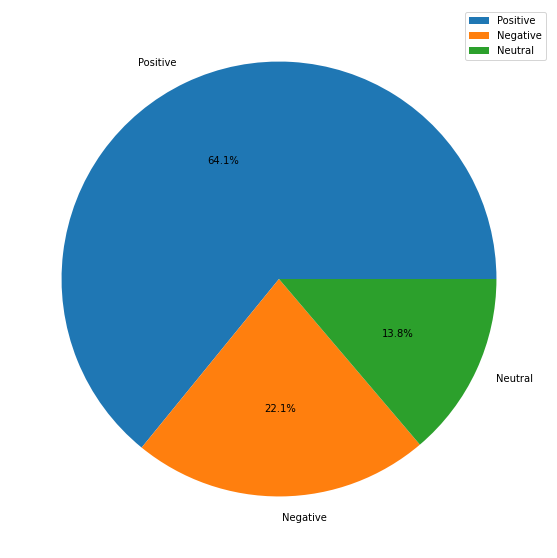

In [12]:
# Filter Data
targetCount = df['Sentiment'].value_counts()
print(targetCount)
# Plot Data
plt.figure(figsize=(10,10))
plt.pie(targetCount,labels=['Positive','Negative','Neutral'],autopct='%1.1f%%')
plt.legend()
plt.show()

Terlihat data yang cukup imbalance terhadap labelnya dimana untul label Positive memiliki hampir setengah dari banyaknya data sebanyak 64.1% data

## The Most Words

C:\Users\mjrum\AppData\Local\Temp\ipykernel_21676\1048028769.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewCount['Translated_Review'] = reviewCount['Translated_Review'].astype(str)


Combination of all reviews: 4274608


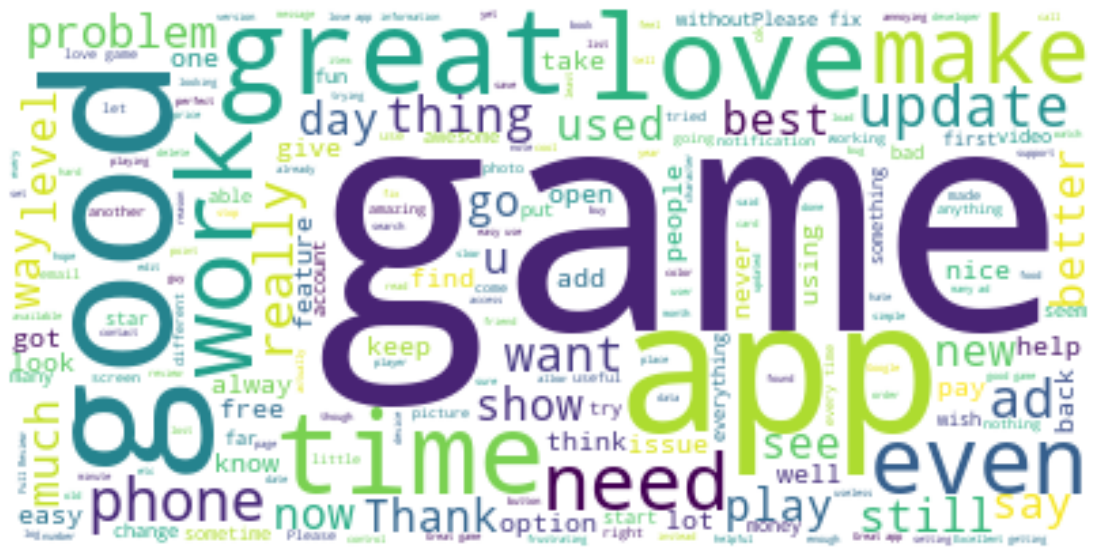

In [13]:
# Filter Data
reviewCount = df[['Translated_Review']]

# Make LowerCase
for rows in range(len(reviewCount)):
    reviewCount.loc[0]['Translated_Review'] = reviewCount.loc[0]['Translated_Review'].lower()

reviewCount['Translated_Review'] = reviewCount['Translated_Review'].astype(str)

textWordCloud = " ".join(x for x in reviewCount['Translated_Review'].head(38000))
print(f'Combination of all reviews: {len(textWordCloud)}')

# Generate Word Cloud
wordCloud = WordCloud(stopwords=set(STOPWORDS), background_color='white').generate(textWordCloud)

# Show World Cloud
plt.figure(figsize=(20,10))
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Dari Word Cloud diatas kita bisa menarik kesimpulan terdapat kata - kata yang sering muncul, dimana kata tersebut beruukuran besar atau bisa kita lihat. Kata yang sering muncul diantaranya : game, app , time, good, word, great, love, make, update, dan sebagainya

## Stop Words

C:\Users\mjrum\AppData\Local\Temp\ipykernel_21676\575143955.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_reviews['stopwords'] = eda_reviews['Translated_Review'].apply(lambda x: len([x for x in x.split() if x in stop_words]))


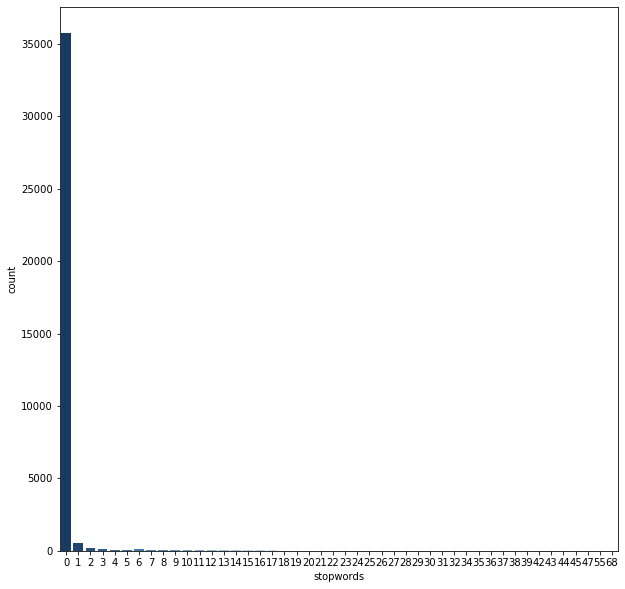

In [14]:
eda_reviews = df[['Translated_Review']]
# Stopwords
stop_words = set(stopwords.words("english"))

eda_reviews['stopwords'] = eda_reviews['Translated_Review'].apply(lambda x: len([x for x in x.split() if x in stop_words]))
eda_reviews[['Translated_Review','stopwords']].head()

# plot Data
plt.figure(figsize=(10,10))
sns.countplot(x='stopwords',data=eda_reviews,palette='RdBu_r')
plt.show()

Terlihat hanya sedikit dari document yang ada , memiliki stopwords, mayoritas corpus tidak memiliki stopwords.

## Punctuation

C:\Users\mjrum\AppData\Local\Temp\ipykernel_21676\1976399725.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_reviews['punctuation'] = eda_reviews['Translated_Review'].apply(lambda x: count_punct(x))


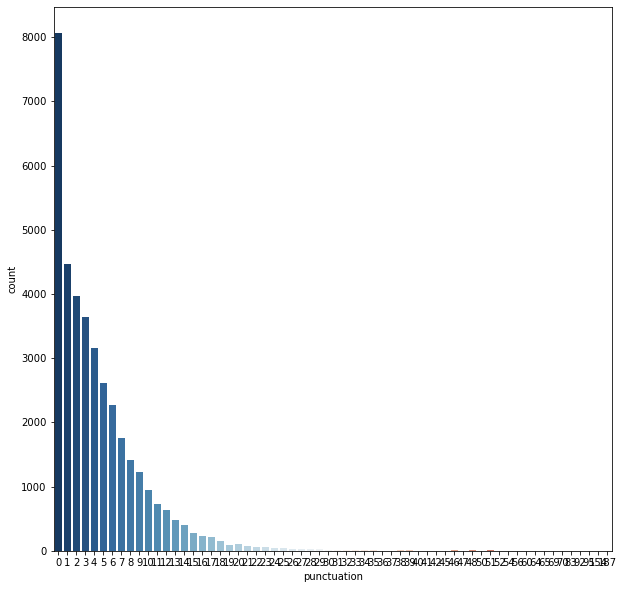

In [15]:
# Punctuation
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return count

eda_reviews['punctuation'] = eda_reviews['Translated_Review'].apply(lambda x: count_punct(x))
eda_reviews[['Translated_Review','punctuation']].head()

# plot Data
plt.figure(figsize=(10,10))
sns.countplot(x='punctuation',data=eda_reviews,palette='RdBu_r')
plt.show()

Terlihat bahwa masih dominant corpus yang tidak memiliki punctuation, semakin banyak jumlah punctuationnya semakit dikit jumlah corpusnya.

## Number 

                                   Translated_Review  numerics
0  I like eat delicious food. That's I'm cooking ...         0
1    This help eating healthy exercise regular basis         0
2         Works great especially going grocery store         0
3                                       Best idea us         0
4                                           Best way         0


C:\Users\mjrum\AppData\Local\Temp\ipykernel_21676\891529053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_reviews['numerics'] = eda_reviews['Translated_Review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))


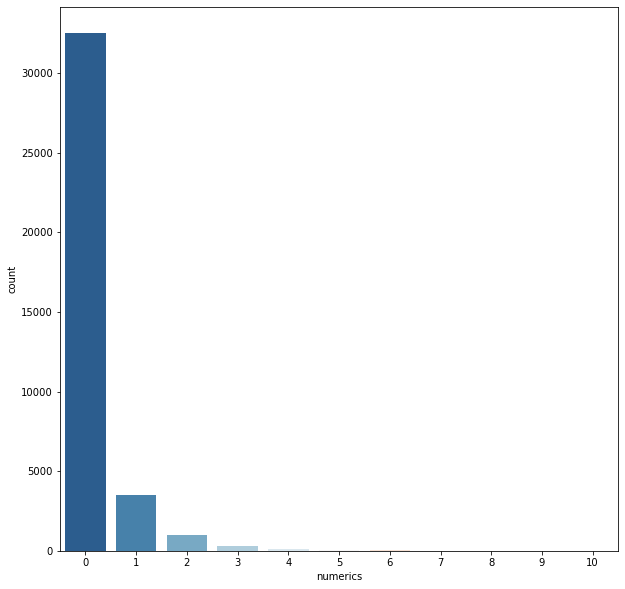

In [16]:
# Numbers / Digits
eda_reviews['numerics'] = eda_reviews['Translated_Review'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
print(eda_reviews[['Translated_Review','numerics']].head())

# plot Data
plt.figure(figsize=(10,10))
sns.countplot(x='numerics',data=eda_reviews,palette='RdBu_r')
plt.show()

Terlihat masih lebih dominant juga untuk corpus yang tidak memiliki angka didalamnya.

## Words Count

                                   Translated_Review  word_count
0  I like eat delicious food. That's I'm cooking ...          21
1    This help eating healthy exercise regular basis           7
2         Works great especially going grocery store           6
3                                       Best idea us           3
4                                           Best way           2


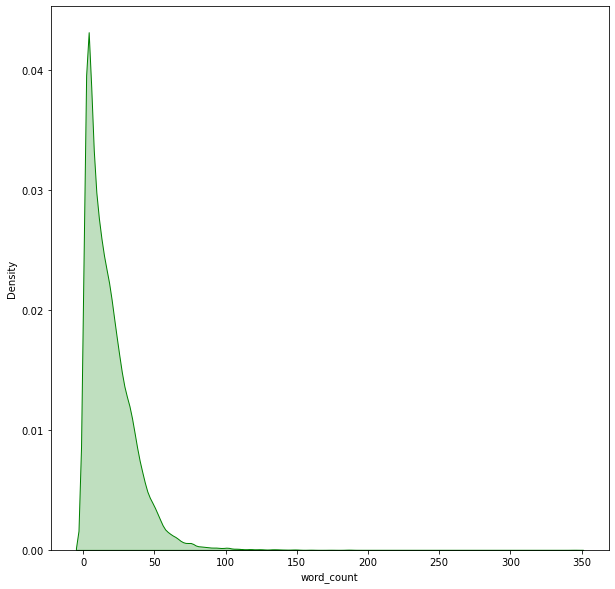

In [17]:
# Number of Words
eda_reviews['word_count'] = eda_reviews['Translated_Review'].apply(lambda x: len(str(x).split(" ")))
print(eda_reviews[['Translated_Review','word_count']].head())
# plot Data
plt.figure(figsize=(10,10))
sns.kdeplot(eda_reviews.word_count,shade=True, color = 'green')
plt.show()

Mayoritas banyak corpus yang memiliki total kata dalam range 0 -50

## Character Count

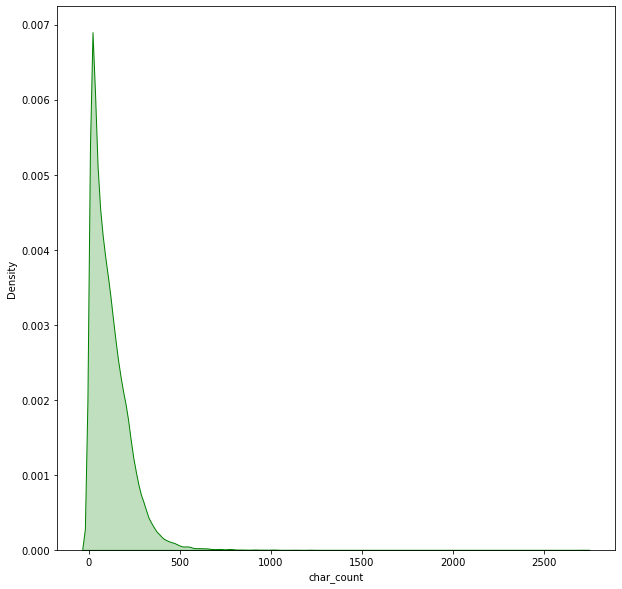

In [18]:
# Number of Character
eda_reviews['char_count'] = eda_reviews['Translated_Review'].str.len()
eda_reviews[['Translated_Review','char_count']].head()

# plot Data
plt.figure(figsize=(10,10))
sns.kdeplot(eda_reviews.char_count,shade=True, color = 'green')
plt.show()

Sama seperti word count begitu juga charactec count dimana mayoritas corpus memiliki jumlah karakter ternya di range 0 - 500

# 5 - Data Preprocessing

## Sample Text Preprocessing

Sebelum kita Melakukan Training kita akan melakukan tex preprocessing untuk menghilangkan hal lain hinga mendapatkan kata saja dalam text datanya. Untuk itu kita akan melakukan test pada satu sample kalimat sebelum merubah semua datanya

In [19]:
# Take Sample Text
sample_text=gpsReviews.loc[15653]['Translated_Review']
print(sample_text)

»TOO BRIGHT!… NIGHT MODE, PLEASE. HOW MANY REQUESTS DO Y'ALL NEED BEFORE YOU IMPLEMENT A DAMN DARK THEME?!!« Also, I can't help feel like lacking lot features make desktop version wonderful... For instance, ★Interface Personalization★. (I mean, call crazy I consider blindingly hideous white bar impossible-to-see-in-sunlight, thin grey font... aesthetically pleasing. It's actually rather ineffective. It's utilitarian depressing horrible.) Please explain personalize bejesus Chrome which, trapped home desktops, inconveniently stationary thus essentially useless (unless plan hella typing)... Yet comes single personal object carried virtually everyday, everyone, everywhere... An object become profoundly integral who/what ARE modern humans. An object, fosters us sense necessity, roughly 94% Americans purportedly "cannot live without it".... When we're considering single profoundly imperative aspect modern existence, smartphone, expectation us content half-assed, visually displeasing, minimal

In [20]:
# Case Folding
sample_text = sample_text.lower()
sample_text = re.sub(r'\d+', ' ', sample_text)
sample_text = re.sub(r'[^\w\s]', ' ', sample_text)
sample_text = re.sub("[^A-Za-z\s']"," ", sample_text)


Kita akan melakukan tahap case folding dimana kita akan menghapus punctuation, angka dan character lainnya.

In [21]:
print(sample_text)

 too bright   night mode  please  how many requests do y all need before you implement a damn dark theme     also  i can t help feel like lacking lot features make desktop version wonderful    for instance   interface personalization    i mean  call crazy i consider blindingly hideous white bar impossible to see in sunlight  thin grey font    aesthetically pleasing  it s actually rather ineffective  it s utilitarian depressing horrible   please explain personalize bejesus chrome which  trapped home desktops  inconveniently stationary thus essentially useless  unless plan hella typing     yet comes single personal object carried virtually everyday  everyone  everywhere    an object become profoundly integral who what are modern humans  an object  fosters us sense necessity  roughly    americans purportedly  cannot live without it      when we re considering single profoundly imperative aspect modern existence  smartphone  expectation us content half assed  visually displeasing  minimali

In [22]:
# Sentence & Word Tokenization
sent_token = sent_tokenize(sample_text)
word_token = word_tokenize(sample_text)

print(sent_token)
print(word_token)

[' too bright   night mode  please  how many requests do y all need before you implement a damn dark theme     also  i can t help feel like lacking lot features make desktop version wonderful    for instance   interface personalization    i mean  call crazy i consider blindingly hideous white bar impossible to see in sunlight  thin grey font    aesthetically pleasing  it s actually rather ineffective  it s utilitarian depressing horrible   please explain personalize bejesus chrome which  trapped home desktops  inconveniently stationary thus essentially useless  unless plan hella typing     yet comes single personal object carried virtually everyday  everyone  everywhere    an object become profoundly integral who what are modern humans  an object  fosters us sense necessity  roughly    americans purportedly  cannot live without it      when we re considering single profoundly imperative aspect modern existence  smartphone  expectation us content half assed  visually displeasing  minima

Selanjutnya kita akan mentokenisasi corpus atau memisahkan corpus menjadi token yang sendiri.

In [23]:
stop_words = set(stopwords.words("english"))
sent_filtered = []

for w in word_token:
    if w not in stop_words:
        sent_filtered.append(w)
        
print("Tokenized Sentence:", word_token)
print("Filtered Sentence:", sent_filtered)

Tokenized Sentence: ['too', 'bright', 'night', 'mode', 'please', 'how', 'many', 'requests', 'do', 'y', 'all', 'need', 'before', 'you', 'implement', 'a', 'damn', 'dark', 'theme', 'also', 'i', 'can', 't', 'help', 'feel', 'like', 'lacking', 'lot', 'features', 'make', 'desktop', 'version', 'wonderful', 'for', 'instance', 'interface', 'personalization', 'i', 'mean', 'call', 'crazy', 'i', 'consider', 'blindingly', 'hideous', 'white', 'bar', 'impossible', 'to', 'see', 'in', 'sunlight', 'thin', 'grey', 'font', 'aesthetically', 'pleasing', 'it', 's', 'actually', 'rather', 'ineffective', 'it', 's', 'utilitarian', 'depressing', 'horrible', 'please', 'explain', 'personalize', 'bejesus', 'chrome', 'which', 'trapped', 'home', 'desktops', 'inconveniently', 'stationary', 'thus', 'essentially', 'useless', 'unless', 'plan', 'hella', 'typing', 'yet', 'comes', 'single', 'personal', 'object', 'carried', 'virtually', 'everyday', 'everyone', 'everywhere', 'an', 'object', 'become', 'profoundly', 'integral', '

Selanjutnya kita mencoba menghilangkan Stopword dari kalimat tersebut.

Lalu kita akan membandingkan mana yang lebih baik untuk kasus iini antara stemming dan lemitization.

In [24]:
# Lexicon Normalization
# Stemming
ps = PorterStemmer()

stemmed_words = []
for w in sent_filtered:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:", sent_filtered)
print("Stemmed Sentence:", stemmed_words)

Filtered Sentence: ['bright', 'night', 'mode', 'please', 'many', 'requests', 'need', 'implement', 'damn', 'dark', 'theme', 'also', 'help', 'feel', 'like', 'lacking', 'lot', 'features', 'make', 'desktop', 'version', 'wonderful', 'instance', 'interface', 'personalization', 'mean', 'call', 'crazy', 'consider', 'blindingly', 'hideous', 'white', 'bar', 'impossible', 'see', 'sunlight', 'thin', 'grey', 'font', 'aesthetically', 'pleasing', 'actually', 'rather', 'ineffective', 'utilitarian', 'depressing', 'horrible', 'please', 'explain', 'personalize', 'bejesus', 'chrome', 'trapped', 'home', 'desktops', 'inconveniently', 'stationary', 'thus', 'essentially', 'useless', 'unless', 'plan', 'hella', 'typing', 'yet', 'comes', 'single', 'personal', 'object', 'carried', 'virtually', 'everyday', 'everyone', 'everywhere', 'object', 'become', 'profoundly', 'integral', 'modern', 'humans', 'object', 'fosters', 'us', 'sense', 'necessity', 'roughly', 'americans', 'purportedly', 'live', 'without', 'considering

In [25]:
# Lemmatization
lemmatized_words = []
lem = WordNetLemmatizer()
for w in sent_filtered:
    lemmatized_words.append(lem.lemmatize(w))
    
print("Filtered Sentence:", sent_filtered)
print("Lemmatized Sentence:", lemmatized_words)

Filtered Sentence: ['bright', 'night', 'mode', 'please', 'many', 'requests', 'need', 'implement', 'damn', 'dark', 'theme', 'also', 'help', 'feel', 'like', 'lacking', 'lot', 'features', 'make', 'desktop', 'version', 'wonderful', 'instance', 'interface', 'personalization', 'mean', 'call', 'crazy', 'consider', 'blindingly', 'hideous', 'white', 'bar', 'impossible', 'see', 'sunlight', 'thin', 'grey', 'font', 'aesthetically', 'pleasing', 'actually', 'rather', 'ineffective', 'utilitarian', 'depressing', 'horrible', 'please', 'explain', 'personalize', 'bejesus', 'chrome', 'trapped', 'home', 'desktops', 'inconveniently', 'stationary', 'thus', 'essentially', 'useless', 'unless', 'plan', 'hella', 'typing', 'yet', 'comes', 'single', 'personal', 'object', 'carried', 'virtually', 'everyday', 'everyone', 'everywhere', 'object', 'become', 'profoundly', 'integral', 'modern', 'humans', 'object', 'fosters', 'us', 'sense', 'necessity', 'roughly', 'americans', 'purportedly', 'live', 'without', 'considering

Kita akan memakai Lemitization karena selain merubah kata kebentuk dasar tidak menghilangkan maksud dari kata tersebut berbeda dengan stemming dimana dia memotong kata sehingga kata jadi tidak bermakna.

## Text Preprocessing

Kita akan membuat Funtion untuk melakukan text preprocessing kepada seluruh corpus dengan urutan yang sudah kita coba pada sample text

In [26]:
# Function Preprocessing for all Text Data

def text_preprocess(text):
    # Case Folding
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub("[^A-Za-z\s']"," ", text)

    word_token = word_tokenize(text)
    # Stop Word Removal
    text_filtered = []
    for w in word_token:
        if w not in stop_words:
            text_filtered.append(w)
    # Lemmatization
    text_lemm = []
    for w in text_filtered:
        text_lemm.append(lem.lemmatize(w))            
    
    text = ' '.join(text_lemm)
    return text

Terlihat hasilnya dibawah ini pada kolom text_processed

In [27]:
gpsReviews['text_processed'] = gpsReviews['Translated_Review'].apply(lambda x: text_preprocess(x))
gpsReviews

,Translated_Review,Sentiment,text_processed
0,I like eat delicious food. That's I'm cooking ...,Positive,like eat delicious food cooking food case best...
1,This help eating healthy exercise regular basis,Positive,help eating healthy exercise regular basis
2,Works great especially going grocery store,Positive,work great especially going grocery store
3,Best idea us,Positive,best idea u
4,Best way,Positive,best way
...,...,...,...
37422,Most ads older many agents ..not much owner po...,Positive,ad older many agent much owner posted detail r...
37423,"If photos posted portal load, fit purpose. I'm...",Positive,photo posted portal load fit purpose sure stor...
37424,"Dumb app, I wanted post property rent give opt...",Negative,dumb app wanted post property rent give option...
37425,I property business got link SMS happy perform...,Positive,property business got link sm happy performanc...


In [28]:
gpsReviews['text_processed'].head(10)

0    like eat delicious food cooking food case best...
1           help eating healthy exercise regular basis
2            work great especially going grocery store
3                                          best idea u
4                                             best way
5                                              amazing
6                                  looking forward app
7                           helpful site help food get
8                                                 good
9    useful information amount spelling error quest...
Name: text_processed, dtype: object

## Label Encoding

Pada Tahap ini kita melakukan proses label encoding untk merubah target kita menjadi angka.

In [29]:
gpsReviews['Sentiment'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [30]:
gpsReviews['label'] = gpsReviews['Sentiment'].replace({'Positive':2,'Negative':0,'Neutral':1})
gpsReviews

,Translated_Review,Sentiment,text_processed,label
0,I like eat delicious food. That's I'm cooking ...,Positive,like eat delicious food cooking food case best...,2
1,This help eating healthy exercise regular basis,Positive,help eating healthy exercise regular basis,2
2,Works great especially going grocery store,Positive,work great especially going grocery store,2
3,Best idea us,Positive,best idea u,2
4,Best way,Positive,best way,2
...,...,...,...,...
37422,Most ads older many agents ..not much owner po...,Positive,ad older many agent much owner posted detail r...,2
37423,"If photos posted portal load, fit purpose. I'm...",Positive,photo posted portal load fit purpose sure stor...,2
37424,"Dumb app, I wanted post property rent give opt...",Negative,dumb app wanted post property rent give option...,0
37425,I property business got link SMS happy perform...,Positive,property business got link sm happy performanc...,2


## Splitting Data

In [31]:
X = gpsReviews[['text_processed']]
y = gpsReviews[['label']]

In [32]:
# Split Data Train and Test
X_train_full, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46, stratify=gpsReviews.label)
print(X_train_full.shape)
print(X_test.shape)

# Split Train and Validation
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train, test_size=0.25, random_state=46, stratify=y_train)
print(X_train.shape)
print(X_val.shape)

(29941, 1)
(7486, 1)
(22455, 1)
(7486, 1)


## Under Sampling

Melakukan handle imbalance dara menggunakan Random Under Sampler dan mentransform data target ke categorical 

In [33]:
undersample = RandomUnderSampler(random_state=46, sampling_strategy='majority')
X_train, y_train = undersample.fit_resample(X_train, y_train)
X_val, y_val = undersample.fit_resample(X_val, y_val)

In [34]:
y_train.value_counts()

label
0        4963
1        3094
2        3094
dtype: int64

In [35]:
y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

## Input Pipeline

In [36]:
train_batch = tf.data.Dataset.from_tensor_slices((X_train, y_train_ohe))
valid_batch = tf.data.Dataset.from_tensor_slices((X_val, y_val_ohe))
test_batch = tf.data.Dataset.from_tensor_slices((X_test, y_test_ohe))

In [37]:
for example, label in train_batch.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  [b'horribly slow app wi fi data load slow time']
label:  [1. 0. 0.]


In [38]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_batch = train_batch.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_batch = valid_batch.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batch = test_batch.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [39]:
for example, label in train_batch.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [[b'photo']
 [b'expensive unless plan spend fortune pack hero nearly impossible really advance much way get hero building unlocked without spending stack cash otherwise lot fun monster scary cool player best batch nerd universe please let u get thing old fashioned way working game earn']
 [b'improve']]

labels:  [[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


Lalu Kita mempersiapkan Input Pipepline untuk memprecepat proses training

## Text Encoder

Disini kita melakukan proses tokenization dan embeding menggunakan layer didalam model architecture, sebelum dimasukkan kedalam model kita akan coba disini dulu.

In [40]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize='lower_and_strip_punctuation',
    ngrams=None,
    output_mode='int',
    output_sequence_length=40,
    input_shape=(1,)
)
encoder.adapt(train_batch.map(lambda text, label: text))

In [41]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'game', 'time', 'get', 'like', 'app', 'ad', 'work',
       'update', 'even', 'good', 'play', 'phone', 'would', 'love',
       'please', 'make', 'great', 'need'], dtype='<U106')

In [42]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 123,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [ 440,  389,  528,  293, 4200,  809, 1606, 1298,  306,   20, 1233,
          36,   32,    4, 1606, 1118, 1092,   74,  600, 2593,  534,  294,
          51,   44, 4018, 2385,  340,  120,   94, 5921, 4009, 6382,   16,
          66,   35,    4,   38,  169, 5542,   32],
       [ 615,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int64)

In [43]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  [b'photo']
Round-trip:  photo                                       

Original:  [b'expensive unless plan spend fortune pack hero nearly impossible really advance much way get hero building unlocked without spending stack cash otherwise lot fun monster scary cool player best batch nerd universe please let u get thing old fashioned way working game earn']
Round-trip:  expensive unless plan spend fortune pack hero nearly impossible really advance much way get hero building unlocked without spending stack cash otherwise lot fun monster scary cool player best batch nerd universe please let u get thing old fashioned way

Original:  [b'improve']
Round-trip:  improve                                       



In [44]:
embedding = Embedding(input_dim=VOCAB_SIZE,
                      output_dim=64,
                      embeddings_initializer="uniform",
                      input_length=40
                      )

# 6 - Model Definition

Pada Kali ini kita akan membuat model untuk Sentimen Anlaysis kita menggunakan RNN Model dimana Kita akan Membuat 2 model dengan architecture yang berbeda kita bandingkan kedua model tersebut lalu salah satu model yang terbaik akan kita lakukan hyperparameter tunning menggunkan random search cv

In [45]:
tf.keras.backend.clear_session()

In [46]:
earlyStopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

## Model 1

In [47]:
model1 = tf.keras.Sequential([
    encoder,
    embedding,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

Pada Model Pertama kita melihat terdapat:
- 1 Text Vectorization Layer, dan 1 Embeding Layer
- 1 LSTM layer digabung dengan Bidirectional Layer dengan neuron 64
- 1 Dense Layer dengan neuron 32 dan activation Function relu
- 1 Output Layer dengan neuron 3 dan activation Function softmax

Untuk menkonfirmasi bekerja sesuai harapan mari kita test dengan 2 kalimat yang pertama tanpa padding dan satu lagi dengan padding

In [49]:
# predict on a sample text without padding.

sample_text = ('The app was cool. The animation and the graphics '
               'were out of this world. I would recommend this app.')
predictions = model1.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 738ms/step
[0.333138   0.33669856 0.33016345]


In [50]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model1.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 29ms/step
[0.333138   0.33669856 0.33016345]


Hasil Kedua Kalimat tersebut seharusnya mirip.

Lalu untuk Compile Model kita melakukannya dengan loss Categorial CrossEntropy, lalu dengan optimizer Adam dan learning rate 1e-4 atau 0.0001 dan metrics accuracy.

In [51]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [52]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 40)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 40, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 710,275
Trainable params: 710,275
Non-trai

## Model 2 

In [53]:
model2 = tf.keras.Sequential([
    encoder,
    embedding,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

Untuk Model Kedua kita akan membuat architecture dengan lebih deep dimana terdapat:
- 1 Text Vectorization Layer, 1 Embedding Layer
- 2 LSTM Layer digabung dengan Bidirectional Layer dengan masing masing nurons 128 dan 64
- 1 Dense Layer dengan neurons 64 dan activation relu
- 1 Layer Dropout dengan nilai 0.5
- dan Output Layer dengan neuron 3 dan activation softmax.

Sama Seperti Model 1 kita akan coba test untuk melihat apakah bekerja sesuai ekpektasi.

In [55]:
# predict on a sample text without padding.

predictions2 = model2.predict(np.array([sample_text]))
print(predictions2[0])

1/1 [==============================] - 1s 1s/step
[0.33378518 0.33269882 0.33351606]


In [56]:
# predict on a sample text with padding
predictions2 = model2.predict(np.array([sample_text, padding]))
print(predictions2[0])

1/1 [==============================] - 0s 16ms/step
[0.33378518 0.33269882 0.33351606]


In [57]:
model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Model dicompile dengan spesifikasi yang sama dengan Model 1

In [58]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 40)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 40, 64)            640000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 40, 256)          197632    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                      

# 7 - Model Training
## Model 1

In [59]:
history1 = model1.fit(train_batch, epochs=50,
                    validation_data=valid_batch, 
                    batch_size = 100,
                    callbacks=[earlyStopping])
                    

Epoch 1/50
175/175 [==============================] - 8s 28ms/step - loss: 1.0607 - accuracy: 0.4809 - val_loss: 0.9915 - val_accuracy: 0.5457
Epoch 2/50
175/175 [==============================] - 4s 23ms/step - loss: 0.9655 - accuracy: 0.5409 - val_loss: 0.9401 - val_accuracy: 0.5600
Epoch 3/50
175/175 [==============================] - 4s 23ms/step - loss: 0.9096 - accuracy: 0.5613 - val_loss: 0.8767 - val_accuracy: 0.5783
Epoch 4/50
175/175 [==============================] - 4s 23ms/step - loss: 0.8042 - accuracy: 0.6261 - val_loss: 0.7459 - val_accuracy: 0.6528
Epoch 5/50
175/175 [==============================] - 4s 25ms/step - loss: 0.6260 - accuracy: 0.7572 - val_loss: 0.6125 - val_accuracy: 0.7695
Epoch 6/50
175/175 [==============================] - 4s 25ms/step - loss: 0.4659 - accuracy: 0.8411 - val_loss: 0.5167 - val_accuracy: 0.8074
Epoch 7/50
175/175 [==============================] - 4s 26ms/step - loss: 0.3416 - accuracy: 0.8911 - val_loss: 0.4618 - val_accuracy: 0.8349

## Model 2

In [60]:
history2 = model2.fit(train_batch, epochs=50,
                    validation_data=valid_batch,
                    batch_size = 100,
                    callbacks=[earlyStopping])
                    

Epoch 1/50
175/175 [==============================] - 21s 91ms/step - loss: 0.8348 - accuracy: 0.6225 - val_loss: 0.4444 - val_accuracy: 0.8491
Epoch 2/50
175/175 [==============================] - 15s 85ms/step - loss: 0.2159 - accuracy: 0.9426 - val_loss: 0.4075 - val_accuracy: 0.8709
Epoch 3/50
175/175 [==============================] - 15s 86ms/step - loss: 0.1605 - accuracy: 0.9570 - val_loss: 0.4741 - val_accuracy: 0.8698
Epoch 4/50
175/175 [==============================] - 15s 84ms/step - loss: 0.1300 - accuracy: 0.9667 - val_loss: 0.5551 - val_accuracy: 0.8666
Epoch 5/50
175/175 [==============================] - 15s 86ms/step - loss: 0.1243 - accuracy: 0.9704 - val_loss: 0.4758 - val_accuracy: 0.8728
Epoch 6/50
175/175 [==============================] - 16s 90ms/step - loss: 0.1024 - accuracy: 0.9770 - val_loss: 0.5409 - val_accuracy: 0.8722
Epoch 7/50
175/175 [==============================] - 16s 92ms/step - loss: 0.0966 - accuracy: 0.9769 - val_loss: 0.4983 - val_accuracy:

# 8 - Model Evaluation

## Model 1

In [61]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 1.1106994561851025)

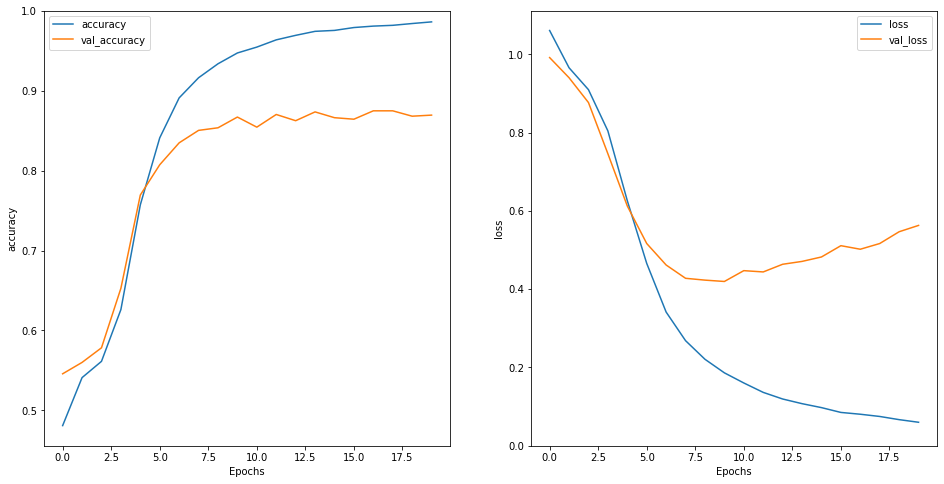

In [62]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history1, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history1, 'loss')
plt.ylim(0, None)

Terlihat model baik dari epoch 0 namun terlihat mendekati epoch kelima model mengalami Overfit

In [63]:
model1.evaluate(test_batch)

117/117 [==============================] - 1s 8ms/step - loss: 0.4853 - accuracy: 0.8414


[0.485271692276001, 0.8414373397827148]

## Model 2

(0.0, 0.8736971132457256)

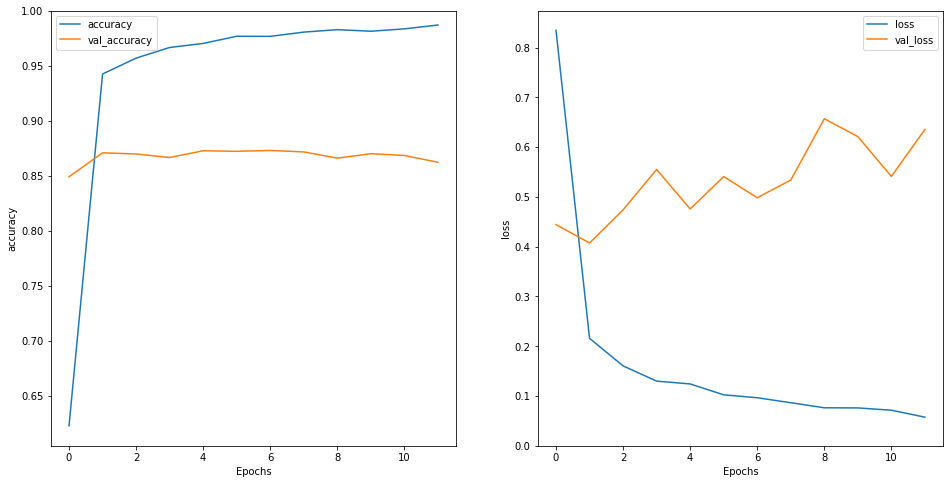

In [64]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history2, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history2, 'loss')
plt.ylim(0, None)

Terlihat Model Masih sangat overfitting untuk itu mari kita coba melakukan Hyper Parameter Tunning pada model kedua ini dengan Random Search CV

In [65]:
model2.evaluate(test_batch)

117/117 [==============================] - 3s 26ms/step - loss: 0.4574 - accuracy: 0.8552


[0.45743027329444885, 0.8551963567733765]

## Hyper Parameter Tunning

In [66]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
def build_model(learning_rate=0.001, first_layer_units = 64 , second_layer_units = 32,lstm_droput = 0.5):
    modelhpt = tf.keras.Sequential()
    modelhpt.add(encoder)
    modelhpt.add(embedding)
    modelhpt.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(first_layer_units,return_sequences=True)))
    modelhpt.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(second_layer_units)))
    modelhpt.add(tf.keras.layers.Dense(64, activation='relu'))
    modelhpt.add(tf.keras.layers.Dropout(lstm_droput))
    modelhpt.add(tf.keras.layers.Dense(3, activation='softmax'))
    modelhpt.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])
    return modelhpt

In [68]:
model2 = tf.keras.Sequential([
    encoder,
    embedding,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model2.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [69]:
keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)

C:\Users\mjrum\AppData\Local\Temp\ipykernel_21676\2189228328.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = tf.keras.wrappers.scikit_learn.KerasRegressor(build_model)


In [70]:
keras_reg.fit(X_train, y_train_ohe, epochs=100,
              validation_data=(X_val, y_val_ohe),
              callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
349/349 [==============================] - 17s 33ms/step - loss: 0.3644 - accuracy: 0.8702 - val_loss: 0.4120 - val_accuracy: 0.8639
Epoch 2/100
349/349 [==============================] - 9s 27ms/step - loss: 0.1600 - accuracy: 0.9544 - val_loss: 0.4388 - val_accuracy: 0.8636
Epoch 3/100
349/349 [==============================] - 9s 27ms/step - loss: 0.1141 - accuracy: 0.9683 - val_loss: 0.4964 - val_accuracy: 0.8583
Epoch 4/100
349/349 [==============================] - 10s 27ms/step - loss: 0.0953 - accuracy: 0.9749 - val_loss: 0.5727 - val_accuracy: 0.8593
Epoch 5/100
349/349 [==============================] - 9s 27ms/step - loss: 0.0784 - accuracy: 0.9795 - val_loss: 0.5885 - val_accuracy: 0.8585
Epoch 6/100
349/349 [==============================] - 9s 27ms/step - loss: 0.0656 - accuracy: 0.9840 - val_loss: 0.6288 - val_accuracy: 0.8577
Epoch 7/100
349/349 [==============================] - 10s 27ms/step - loss: 0.0535 - accuracy: 0.9866 - val_loss: 0.8344 - val_accura

In [71]:
y_pred1 = keras_reg.predict(X_test)

234/234 [==============================] - 3s 7ms/step


In [72]:
np.random.seed(42)
tf.random.set_seed(42)

param_distribs = {
    "first_layer_units": [32,64,128],
    "second_layer_units": [16,32,64],
    "lstm_droput":[0.5,0.4,0.3]
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train_ohe, epochs=50,
                  validation_data=(X_val, y_val_ohe),
                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/50
233/233 [==============================] - 13s 32ms/step - loss: 0.2686 - accuracy: 0.9002 - val_loss: 0.6632 - val_accuracy: 0.8373
Epoch 2/50
233/233 [==============================] - 6s 26ms/step - loss: 0.0533 - accuracy: 0.9860 - val_loss: 0.7492 - val_accuracy: 0.8346
Epoch 3/50
233/233 [==============================] - 6s 26ms/step - loss: 0.0391 - accuracy: 0.9907 - val_loss: 0.7522 - val_accuracy: 0.8510
Epoch 4/50
233/233 [==============================] - 6s 26ms/step - loss: 0.0336 - accuracy: 0.9923 - val_loss: 0.9010 - val_accuracy: 0.8429
Epoch 5/50
233/233 [==============================] - 6s 25ms/step - loss: 0.0273 - accuracy: 0.9941 - val_loss: 0.9042 - val_accuracy: 0.8362
Epoch 6/50
233/233 [==============================] - 6s 26ms/step - loss: 0.0278 - accuracy: 0.9939 - val_loss: 1.0574 - val_accuracy: 0.8187
Epoch 7/50
233/233 [==============================] - 6s 26ms/step - loss: 0.028

RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x00000251069560D0>,
                   param_distributions={'first_layer_units': [32, 64, 128],
                                        'lstm_droput': [0.5, 0.4, 0.3],
                                        'second_layer_units': [16, 32, 64]},
                   verbose=2)

In [73]:
rnd_search_cv.best_params_

{'second_layer_units': 16, 'lstm_droput': 0.3, 'first_layer_units': 128}

## Model After HyperParameter Tunning

In [88]:
modelhpt = tf.keras.Sequential([
    encoder,
    embedding,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

modelhpt.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [90]:
historyhpt = modelhpt.fit(train_batch, epochs=50,
                    validation_data=valid_batch,
                    batch_size = 50,
                    callbacks=[earlyStopping])

Epoch 1/50
175/175 [==============================] - 40s 227ms/step - loss: 0.0989 - accuracy: 0.9901 - val_loss: 0.6500 - val_accuracy: 0.8322
Epoch 2/50
175/175 [==============================] - 42s 239ms/step - loss: 0.0407 - accuracy: 0.9926 - val_loss: 0.7513 - val_accuracy: 0.8311
Epoch 3/50
175/175 [==============================] - 43s 248ms/step - loss: 0.0289 - accuracy: 0.9944 - val_loss: 0.7898 - val_accuracy: 0.8351
Epoch 4/50
175/175 [==============================] - 43s 246ms/step - loss: 0.0250 - accuracy: 0.9955 - val_loss: 0.8496 - val_accuracy: 0.8306
Epoch 5/50
175/175 [==============================] - 43s 243ms/step - loss: 0.0211 - accuracy: 0.9955 - val_loss: 0.9261 - val_accuracy: 0.8246
Epoch 6/50
175/175 [==============================] - 42s 242ms/step - loss: 0.0181 - accuracy: 0.9965 - val_loss: 0.9565 - val_accuracy: 0.8311
Epoch 7/50
175/175 [==============================] - 42s 241ms/step - loss: 0.0171 - accuracy: 0.9966 - val_loss: 0.9999 - val_ac

(0.0, 1.127517014509067)

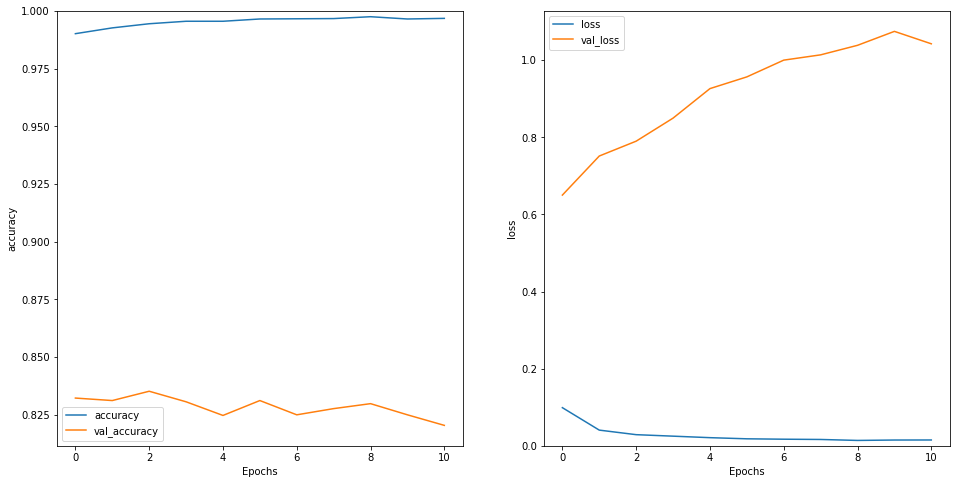

In [91]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(historyhpt, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(historyhpt, 'loss')
plt.ylim(0, None)

In [92]:
modelhpt.evaluate(test_batch)

117/117 [==============================] - 7s 62ms/step - loss: 0.7758 - accuracy: 0.8022


[0.7758153676986694, 0.8021640181541443]

Setelah dilakukan HyperParameter Tunnning Model 2 Masih tidak lebih baik dari model 1 Sehingga kita akan save model 1.

## Test Model To predict 

In [93]:
yPredictedSeq = model1.predict(test_batch)

117/117 [==============================] - 3s 22ms/step


In [94]:
y_pred = []
for i in range(len(yPredictedSeq)):
    index = np.where(yPredictedSeq[i] == yPredictedSeq[i].max())
    res = functools.reduce(lambda sub, ele: sub * 10 + ele, index)
    if res == 0 :
        y_pred.append(0)
    elif res == 1 :
        y_pred.append(1)
    elif res == 2 :
        y_pred.append(2)

Text(51.0, 0.5, 'Actual')

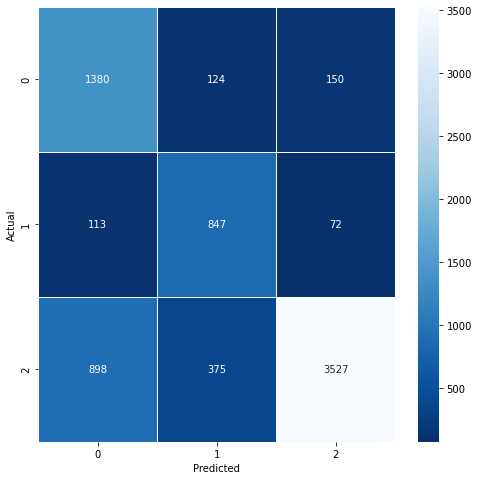

In [95]:
cm = tf.math.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap='Blues_r')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Terlihat masih terdapat nilai FN dan FP yang Cukup besar Dimana FN =721 dan FP = 1011 namun tidak lebih besar daripada TP dan TN nya

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.83      0.68      1654
           1       0.63      0.82      0.71      1032
           2       0.94      0.73      0.83      4800

    accuracy                           0.77      7486
   macro avg       0.72      0.80      0.74      7486
weighted avg       0.82      0.77      0.78      7486



Terlihat accuracy 0.77 yang cukup baik, dimana model ini masih lebih baik dalam memprediksi sentimen positive. Hal ini mungkin terjadi dikarena data yang kurang untuk training karena melakukan undersampling.

# 9 - Model Saving

In [82]:
filepath = "model"
model2.save(filepath, save_format="tf")

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


# 10 - Inference Model

In [83]:
model = tf.keras.models.load_model("model")

In [84]:
new_data = {'text_processed':["Best game I've played since 2012, I just saw a few reviews mentioning that they cannot hear the music or the music discs. This is due to the music being a separate download in the store. Don't worry, it's free, just look through the game store's free downloads and you should find the music pack"]}
new_data = pd.DataFrame(new_data)

In [85]:
y_inf = model.predict(new_data)

1/1 [==============================] - 1s 1s/step


In [86]:
a = []
b = []
for i in range(len(y_inf)):
    index = np.where(y_inf[i] == y_inf[i].max())
    res = functools.reduce(lambda sub, ele: sub * 10 + ele, index)
    if res == 0 :
        a.append(0)
        b.append("Negative")
    elif res == 1 :
        a.append(1)
        b.append("Netral")
    elif res == 2 :
        a.append(2)
        b.append("Positive")

In [87]:
print('Sentence:', new_data['text_processed'])
print('Prediction:', b)

Sentence: 0    Best game I've played since 2012, I just saw a...
Name: text_processed, dtype: object
Prediction: ['Positive']


# 11 - Pengambilan Kesimpulan

## Hasil EDA :
- Terlihat data yang cukup imbalance terhadap labelnya dimana untul label Positive memiliki hampir setengah dari banyaknya data sebanyak 64.1% data
- Dari Word Cloud diatas kita bisa menarik kesimpulan terdapat kata - kata yang sering muncul, dimana kata tersebut beruukuran besar atau bisa kita lihat. Kata yang sering muncul diantaranya : game, app , time, good, word, great, love, make, update, dan sebagainya
- Terlihat hanya sedikit dari document yang ada , memiliki stopwords, mayoritas corpus tidak memiliki stopwords.
- Terlihat bahwa masih dominant corpus yang tidak memiliki punctuation, semakin banyak jumlah punctuationnya semakit dikit jumlah corpusnya.
- Terlihat masih lebih dominant juga untuk corpus yang tidak memiliki angka didalamnya.
- Mayoritas banyak corpus yang memiliki total kata dalam range 0 - 50 dan total character dalam rang 0 - 500


## Hasil Model:
- Membuat 2 Model dengan architecture yang berbeda 

    Pada Model 1 kita melihat terdapat:
    - 1 Text Vectorization Layer, dan 1 Embeding Layer
    - 1 LSTM layer digabung dengan Bidirectional Layer dengan neuron 64
    - 1 Dense Layer dengan neuron 32 dan activation Function relu
    - 1 Output Layer dengan neuron 3 dan activation Function softmax

    Untuk Model 2 kita akan membuat architecture dengan lebih deep dimana terdapat:
    - 1 Text Vectorization Layer, 1 Embedding Layer
    - 2 LSTM Layer digabung dengan Bidirectional Layer dengan masing masing nurons 128 dan 64
    - 1 Dense Layer dengan neurons 64 dan activation relu
    - 1 Layer Dropout dengan nilai 0.5
    - dan Output Layer dengan neuron 3 dan activation softmax.


- Lalu dilakukan Hyper Parameter tunning untuk mencari nilai neuron dan nilai dropoutnya. Setelah dilihat hasilnya dar Model ke 2 tidak lebih baik dari Model 1 

- Untuk itu Model 1 disave untuk dilakukan Inference.

- Kelebihan Model 1 Baik dalam Memprediksi Sentimen Positive 
- Kelemahan Model 1 selbaliknya masih lemah dalam memprediksi Sentimen Negative
- Model 1 Belum dilakukan Hyperparameter kemungkinan performa dapat meningkat
